# IPBME6UE: Problem Set 2 - Medical Image Processing

## Spring 2023

## Group Members

**Person 1:**

YOUR NAME HERE

**Person 2:**

YOUR NAME HERE

Welcome to Problem Set 2!

In this problem set, we will be exploring some fundamental concepts in digital image processing and will perform segmentation and classification of tumors and leisons in imaging.

Breast cancer (BC) is the most commonly diagnosed malignant disease and [the leading cause of cancer death in women in Austria](https://pubmed.ncbi.nlm.nih.gov/35487918/).

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, or at least in our course..."

Treat this as a mini-project. We highly encourage working with 1 other person.


## Problem 1: Image Segmentation (30 points)


Download the [segmentation dataset (~200 MB)](https://imcfhkrems.sharepoint.com/:u:/r/teams/LV_62825/Class%20Materials/Exercise%202/Dataset_BUSI_with_GT.zip?csf=1&web=1&e=fpNqjR).

The dataset is divided into benign, malignant, and normal ultrasound imaging with binary masking.

**a.** Your first task is to segment the images. You may use any of the segmentation algorithms we saw in class. You can ignore the tumor-type division and use all the images but keep track of the method's performance per tumor type for the report in the next section. For the adventurist in you, try using deep learning to generate an initial ROI and active contours to shape that initial ROI into the final segmentation contour. Evaluate your results using an appropriate segmentation metric compared to the ground-truth labels as the target.


In [12]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.12.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# # Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
import cv2
import os
import matplotlib.pyplot as plt

from skimage.segmentation import active_contour
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from skimage import exposure, filters, morphology

from skimage.filters import gaussian




In [66]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################

def segment_images(image_dir,masks_dir):


  
  threshold_value = 127

  # kernel for post-processing
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))


  # parameters for region growing
  region_threshold = 0.5
  max_iterations = 10000

  # function for getting neighbors of a pixel
  def get_neighbors(pixel, shape):
      neighbors = []
      row, col = pixel
      if row > 0:
          neighbors.append((row - 1, col))
      if row < shape[0] - 1:
          neighbors.append((row + 1, col))
      if col > 0:
          neighbors.append((row, col - 1))
      if col < shape[1] - 1:
          neighbors.append((row, col + 1))
      return neighbors




  count = 0
  for root, dirs, files in os.walk(image_dir):
      for file in files:
          if file.endswith('.png'):
              if count == 1:
                  break
           
              img_path = os.path.join(root, file)
            
              mask_path = os.path.join(masks_dir, file.replace('.png', '_mask.png'))
        
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


              _, img_thresholded = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)
              _, mask_thresholded = cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)


              img_processed = cv2.erode(img_thresholded, kernel, iterations=1)
              mask_processed = cv2.erode(mask_thresholded, kernel, iterations=1)
              

              image = io.imread(img_path)

              image_eq = exposure.equalize_hist(image)


              image_smooth = filters.gaussian(image_eq, sigma=1)




              image_clahe = exposure.equalize_adapthist(image_smooth, clip_limit=0.03)


              #edge detection
              edges = cv2.Canny(image, 100, 200)


                            
                                          
              # Initialize contour using a circular shape
              s = np.linspace(0, 2*np.pi, 400)
              x = 316 + 30*np.cos(s)
              y = 150 + 30*np.sin(s)
              init_contour = np.array([x, y]).T

              #energy function parameters
              alpha = 0.008 # elasticity parameter
              beta = 100 # rigidity parameter
              gamma = 0.1 # smoothing parameter

              # active contour segmentation
              snake = active_contour(image_clahe, init_contour, alpha=alpha, beta=beta, gamma=gamma)



              # region growing segmentation on the thresholded image and mask
              img_segmented_rg = np.zeros(img_processed.shape, np.uint8)
              for i in range(img_processed.shape[0]):
                  for j in range(img_processed.shape[1]):
                      if mask_processed[i,j] == 255:
                          seed = (i, j)
                          region = set([seed])
                          intensity_threshold = img_processed[seed] * (1 - region_threshold)
                          processed_pixels = set()
                          for k in range(max_iterations):
                              if not region:
                                  break
                              pixel = region.pop()
                              processed_pixels.add(pixel)
                              if img_processed[pixel] >= intensity_threshold:
                                  img_segmented_rg[pixel] = 255
                                  neighbors = get_neighbors(pixel, img_processed.shape)
                                  for neighbor in neighbors:
                                      if neighbor not in processed_pixels:
                                          region.add(
                                              neighbor)


              # Plot of the original image, thresholded image, and segmented image
              fig, ax = plt.subplots(2, 3, figsize=(15, 10))
              plt.subplots_adjust(wspace=0.3, hspace=0.3)

              ax[0, 0].imshow(img, cmap='gray')
              ax[0, 0].set_title('Original Image')

              ax[0, 1].imshow(img_processed, cmap='gray')
              ax[0, 1].set_title('Thresholded')

              ax[1, 0].imshow(img_segmented_rg, cmap='gray')
              ax[1, 0].set_title('Region Growing')

              

              ax[0, 2].imshow(mask, cmap='gray')
              ax[0, 2].set_title('Original Mask')

              ax[1, 1].imshow(edges, cmap='gray')
              ax[1, 1].set_title('Edge detection')

              

              plt.show()





              count += 1

######################################################################################################

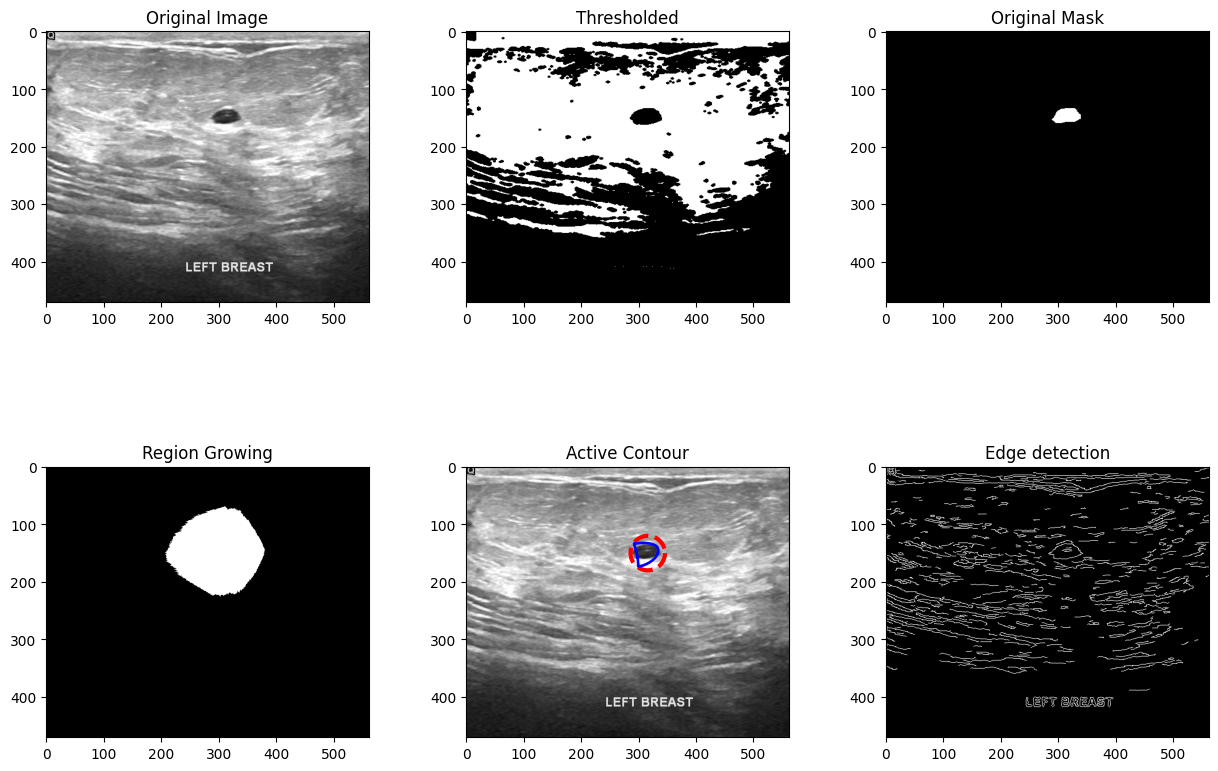

In [59]:
benign_image_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/benign/images'
benign_masks_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/benign/masks'
segment_images(benign_image_dir,benign_masks_dir)


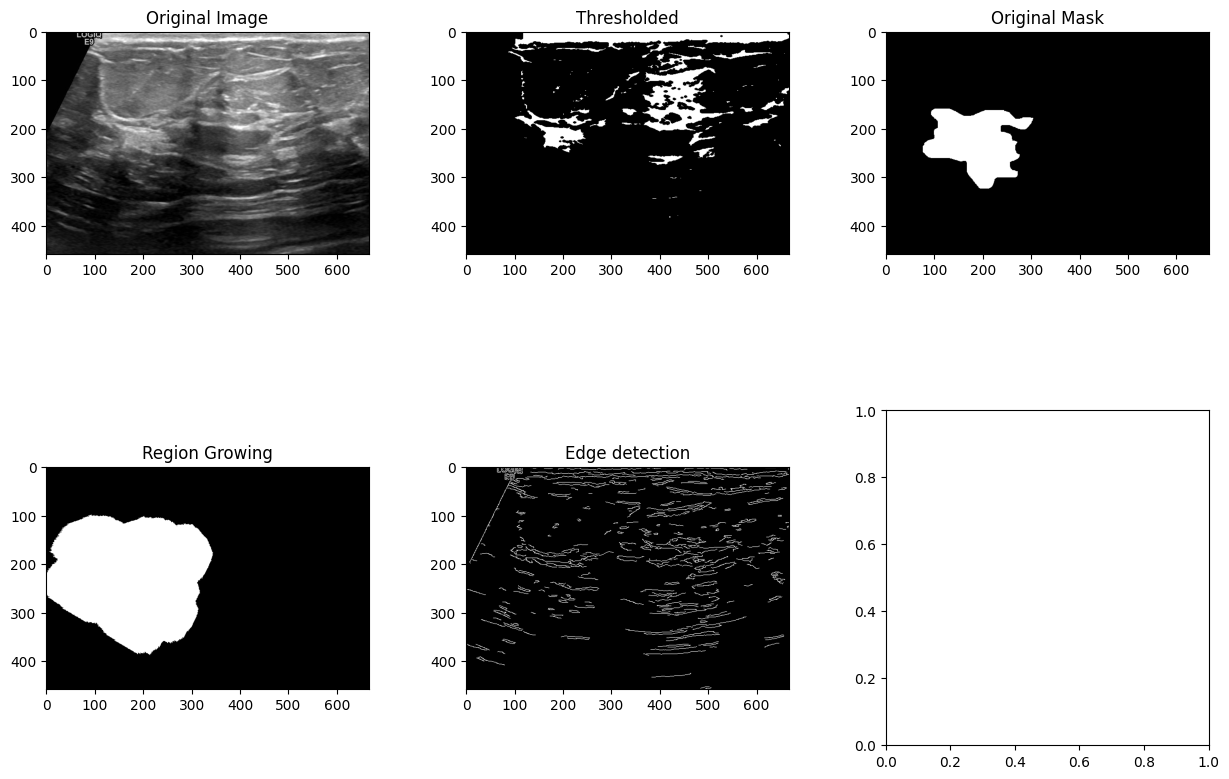

In [61]:
malignant_image_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/malignant/images'
malignant_masks_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/malignant/masks'

segment_images(malignant_image_dir,malignant_masks_dir)  

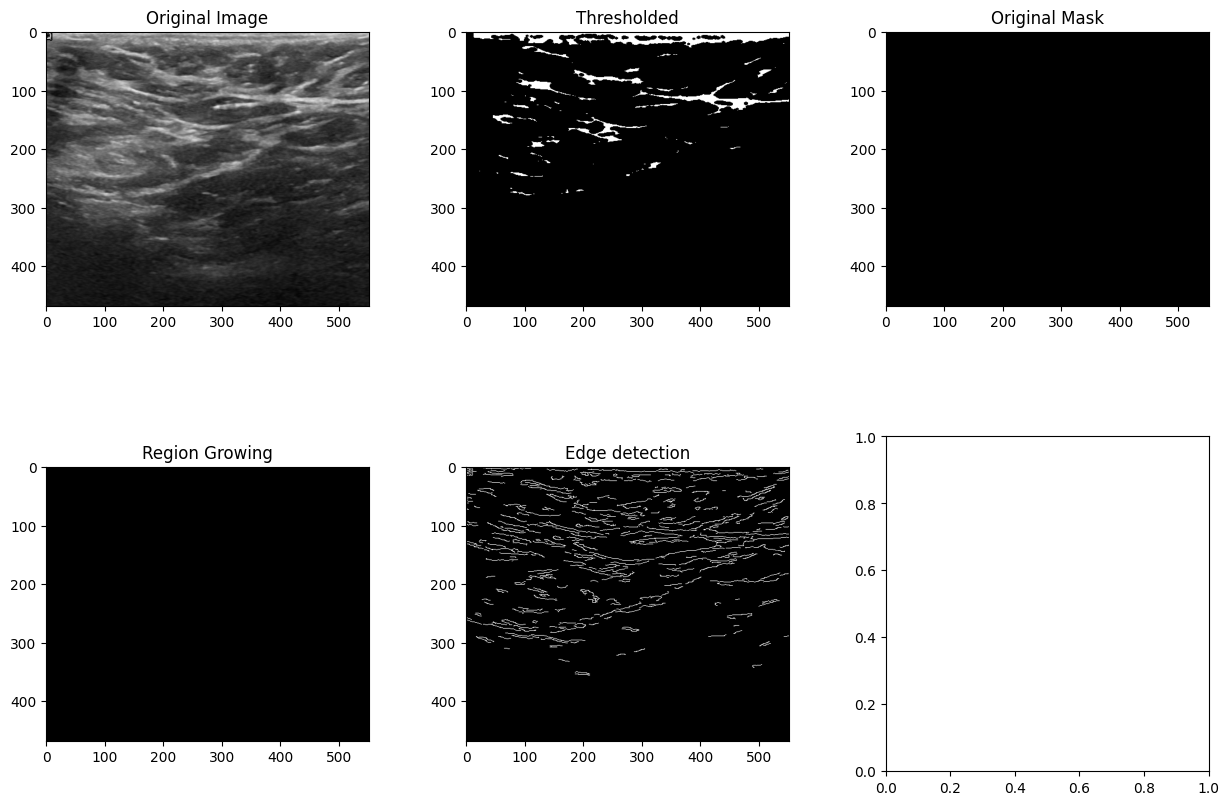

In [67]:
normal_image_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/normal/images'
normal_masks_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/normal/masks'
segment_images(normal_image_dir,normal_masks_dir)


<ipython-input-53-db3faa6d8833>:70: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  snake_malignant = active_contour(image_malignant, init_contour_malignant, alpha=alpha, beta=beta, gamma=gamma,max_iterations=num_iterations)


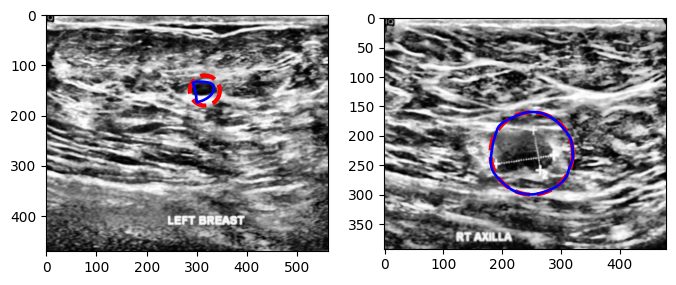

In [53]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################



def preprocess_image(image):

  image_eq = exposure.equalize_hist(image)

  image_smooth = filters.gaussian(image_eq, sigma=1)

  image_clahe = exposure.equalize_adapthist(image_smooth, clip_limit=0.03)

  return image_clahe

 

image_benign = preprocess_image(io.imread('/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/benign/images/benign (1).png'))          
                            
# Initialize contour using a circular shape
s = np.linspace(0, 2*np.pi, 400)
x = 316 + 30*np.cos(s)
y = 150 + 30*np.sin(s)
init_contour_benign = np.array([x, y]).T

# Define energy function parameters
alpha = 0.008 # elasticity parameter
beta = 100 # rigidity parameter
gamma = 0.1 # smoothing parameter


 # Run active contour segmentation
snake_benign = active_contour(image_benign, init_contour_benign, alpha=alpha, beta=beta, gamma=gamma)


#####################################################################
###################malignant###########################################
#####################################################################




image_malignant = preprocess_image(io.imread('/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/malignant/images/malignant (12).png'))  
mask_malignant = io.imread('/content/drive/MyDrive/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/malignant/masks/malignant (12)_mask.png')

# Initialize contour using a circular shape
s = np.linspace(0, 2*np.pi, 400)
x = 250 + 70*np.cos(s)
y = 230 + 70*np.sin(s)
init_contour_malignant = np.array([x, y]).T

# Define energy function parameters
alpha = 0.5 # elasticity parameter
beta = 100 # rigidity parameter
gamma = 0.5 # smoothing parameter


num_iterations=1000
 # Run active contour segmentation
snake_malignant = active_contour(image_malignant, init_contour_malignant, alpha=alpha, beta=beta, gamma=gamma,max_iterations=num_iterations)



# Visualize result
fig, ax = plt.subplots(1,2, figsize=(8, 8))
ax[0].imshow(image_benign)
ax[0].plot(init_contour_benign[:, 0], init_contour_benign[:, 1], '--r', lw=3)
ax[0].plot(snake_benign[:, 0], snake_benign[:, 1], '-b', lw=1.9)


ax[1].imshow(image_malignant)
ax[1].plot(init_contour_malignant[:, 0], init_contour_malignant[:, 1], '--r', lw=3)
ax[1].plot(snake_malignant[:, 0], snake_malignant[:, 1], '-b', lw=1.9)


plt.show()



######################################################################################################

**b.** Create a report of your segmentation efforts.
Try answering the following questions:
- Which methods did you try? Can you reason your choices? 
- Which method worked the best for you? Which method worked the worst? Can you think why?

- How well did your methods work per class (benign, malignant, and normal)? 

###Report
* The methods used include Thresholding, Active contour, edge detection and region growing.
* The choice of the segmentation methods depends on the images as well, thresholding is a simple and fast way to segment an image and works well when the foreground and background of an image have high contrast. On the other hand, region growing can be useful when the edges of objects in an image are not well defined.
* thresholding, region growing and active contour performed well for benign images,for the malignant images active contour was time consuming and requires alot of parameter tuning. For the normal images the region growing method performed best.

**Answer:**

## Problem 2: Geometric Features (21 points)

As you may know, the geometric features of a tumor can sometimes reveal significant information about whether it is *benign* or *malignant*. [Radiologists frequently assess the geometry of lesions in mammograms when attempting to diagnose breast cancer](https://www.sciencedirect.com/science/article/pii/S2211568413003872).

In this exercise, we will attempt to explore some quantitative methods of differentiating between certain lesion shapes.

Download the two mammograms from Teams: `LEFT_CC_BENIGN.tif` depicts a cranial-caudal view (looking down on the breast from the patient's perspective) of the left breast. There is a benign lesion present in the mammogram. Can you locate it? 

If you are having difficulty locating the lesion, try seeing if you can spot it in the mask `LEFT_CC_BENIGN_MASK.tif`, which consists of a rough segmentation of the lesion. `RIGHT_CC_MALIGNANT.tif` and `RIGHT_CC_MALIGNANT_MASK.tif` are the mammogram and corresponding lesion segmentation of a different patient, but this mammogram depicts a breast with a **malignant** tumor.

**a.** Start by loading these two mammograms and their corresponding masks as image matrices. 
Plot them on a single figure (e.g., using a 2-by-2 grid of subplots). You should use reasonable **x** and **y** limits in your figures to get a reasonable depiction of your lesion segmentations.

Qualitatively describe the shape differences between the two lesions. What types of shapes and margins are indicative of malignant tumors?

**Answer:**
Malignant tumors  have irregular and spiculated margins, meaning the edges of the tumor are not smooth and have small projections. In contrast, benign tumors have well-defined, smooth, and round or oval shapes.

<ipython-input-4-8018714c98c6>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  left_cc_benign = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/LEFT_CC_BENIGN.tif')
<ipython-input-4-8018714c98c6>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  left_cc_benign_mask = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/LEFT_CC_BENIGN_MASK.tif')
<ipython-input-4-8018714c98c6>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2

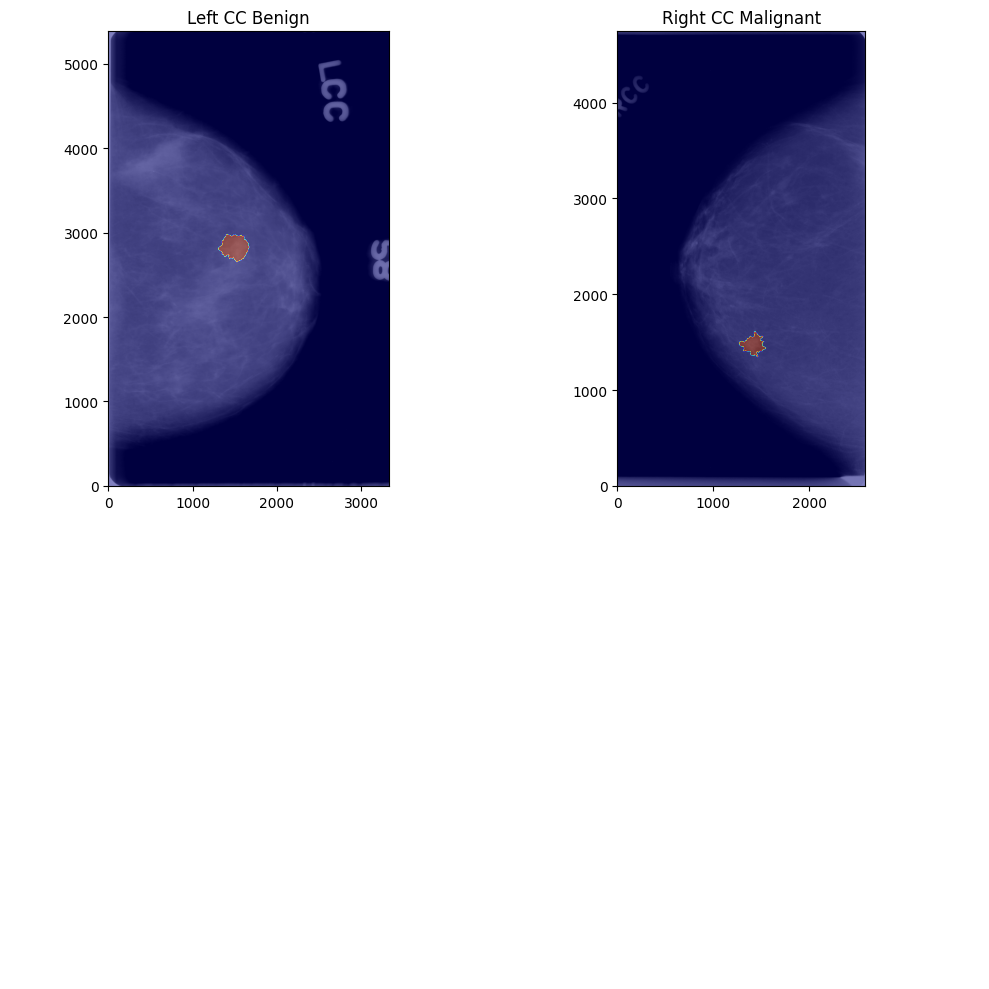

In [ ]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######
import matplotlib.pyplot as plt
import imageio

#mammograms and their corresponding masks as image matrices
left_cc_benign = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/LEFT_CC_BENIGN.tif')
left_cc_benign_mask = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/LEFT_CC_BENIGN_MASK.tif')
right_cc_malignant = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/RIGHT_CC_MALIGNANT.tif')
right_cc_malignant_mask = imageio.imread('/content/drive/MyDrive/BENIGN_MALIGNANT/RIGHT_CC_MALIGNANT_MASK.tif')

#figure with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# x and y limits to the extent of the mammograms and masks
left_cc_benign_extent = [0, left_cc_benign.shape[1], 0, left_cc_benign.shape[0]]
left_cc_benign_mask_extent = [0, left_cc_benign_mask.shape[1], 0, left_cc_benign_mask.shape[0]]
right_cc_malignant_extent = [0, right_cc_malignant.shape[1], 0, right_cc_malignant.shape[0]]
right_cc_malignant_mask_extent = [0, right_cc_malignant_mask.shape[1], 0, right_cc_malignant_mask.shape[0]]

# left CC mammogram and its mask in the top left subplot
axs[0,0].imshow(left_cc_benign, cmap='gray', extent=left_cc_benign_extent)
axs[0,0].imshow(left_cc_benign_mask, alpha=0.5, cmap='jet', extent=left_cc_benign_mask_extent)
axs[0,0].set_title('Left CC Benign')
axs[0,0].set_xlim(left_cc_benign_extent[0], left_cc_benign_extent[1])
axs[0,0].set_ylim(left_cc_benign_extent[2], left_cc_benign_extent[3])

# right CC mammogram and its mask in the top right subplot
axs[0,1].imshow(right_cc_malignant, cmap='gray', extent=right_cc_malignant_extent)
axs[0,1].imshow(right_cc_malignant_mask, alpha=0.5, cmap='jet', extent=right_cc_malignant_mask_extent)
axs[0,1].set_title('Right CC Malignant')
axs[0,1].set_xlim(right_cc_malignant_extent[0], right_cc_malignant_extent[1])
axs[0,1].set_ylim(right_cc_malignant_extent[2], right_cc_malignant_extent[3])

# Hide the empty subplots
axs[1,0].axis('off')
axs[1,1].axis('off')

fig.tight_layout()


######################################################################################################


**b.** Next, try computing some basic geometric features of the two lesions. Which features are the most significant for differentiating between them? Is this what you expected? The `regionprops()` function in the `skimage` library will automatically compute several geometric features for you, but you might choose to code up some of your own. If you don't trust the provided segmentations, feel free to create your segmentation method or modify the provided ones to get a better estimate of the lesion shapes! Finally, it could be interesting to apply some edge-detection filters to the mammograms to better emphasize the margins. 

You can also test your approach on other mammograms from a [larger dataset (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH). 

**There is no single correct answer for this exercise, and you should definitely try several different approaches and explore!**

In [ ]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################

from skimage.measure import regionprops

# properties of the benign lesion mask
benign_props = regionprops(left_cc_benign_mask)

# properties of the malignant tumor mask
tumor_props = regionprops(right_cc_malignant_mask)

# some basic properties for each object
for props in [benign_props[0], tumor_props[0]]:
    print('Object: ', props.label)
    print('  Area: ', props.area)
    print('  Perimeter: ', props.perimeter)
    print('  Eccentricity: ', props.eccentricity)
    print('  Solidity: ', props.solidity)
    print('  Major axis length: ', props.major_axis_length)
    print('  Minor axis length: ', props.minor_axis_length)











######################################################################################################

Object:  255
  Area:  79149
  Perimeter:  1696.481456229631
  Eccentricity:  0.47720615771178426
  Solidity:  0.8917895733101979
  Major axis length:  342.7521219562273
  Minor axis length:  301.2076089802862
Object:  255
  Area:  35508
  Perimeter:  1499.2844507162113
  Eccentricity:  0.48442444413376373
  Solidity:  0.7168843754416426
  Major axis length:  241.24170593425896
  Minor axis length:  211.04623015081276


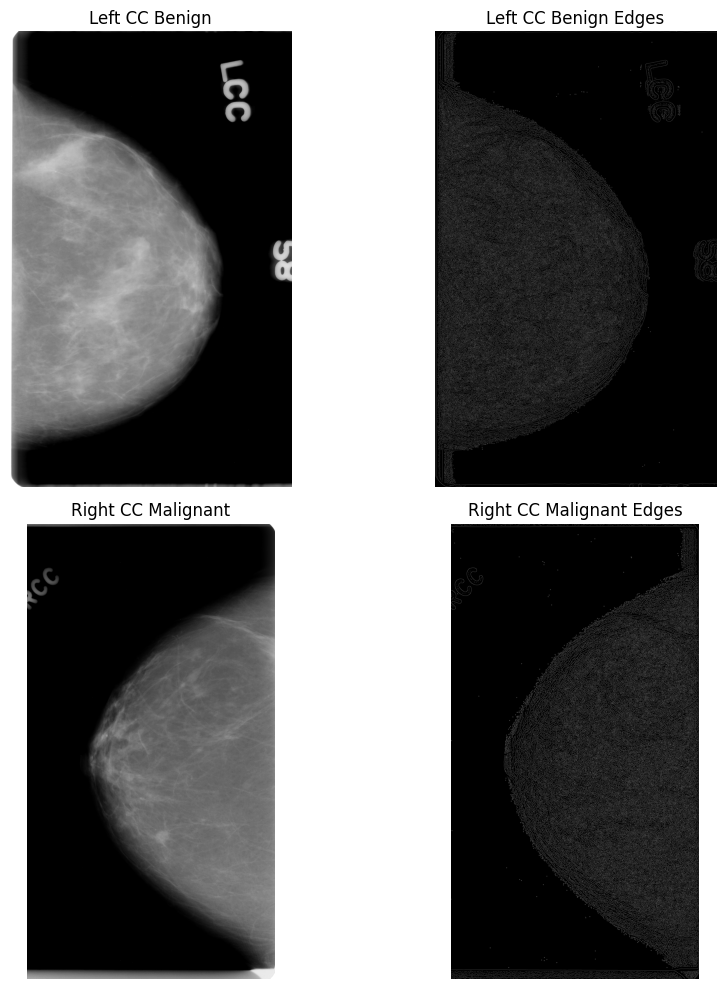

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from skimage.feature import canny

# Canny edge detection filter with a low threshold value to the left_cc_benign image
edges_low = canny(left_cc_benign, sigma=3, low_threshold=0.01, high_threshold=0.1)

# Canny edge detection filter with a high threshold value to the right_cc_malignant image
edges_high = canny(right_cc_malignant, sigma=3, low_threshold=0.1, high_threshold=0.3)

# Plot the original images and their corresponding edge-detected images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax = axes.ravel()

ax[0].imshow(left_cc_benign, cmap='gray')
ax[0].set_title('Left CC Benign')

ax[1].imshow(edges_low, cmap='gray')
ax[1].set_title('Left CC Benign Edges')

ax[2].imshow(right_cc_malignant, cmap='gray')
ax[2].set_title('Right CC Malignant')

ax[3].imshow(edges_high, cmap='gray')
ax[3].set_title('Right CC Malignant Edges')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()




**c.** Computing GLCMs over the entire image is generally not very useful. Any subtle changes in lesion texture could make a significant difference in terms of the radiologist's diagnosis, but it might only result in a minimal change in the image's GLCM. A simple solution is to break the image down into chunks and compute a localized GLCM of each image chunk.

Try doing this on *one* of the provided mammograms. Iterate through the full mammogram and extract overlapping chunks (similar to what you would do when computing a 2D convolution), then compute the GLCM of each chunk. From each GLCM, compute your favorite Haralick texture feature and save it to a separate matrix. If you've done this correctly, you should be able to produce a textural feature map that is about the same size as your image. Plot this texture map alongside the original image. Does it look like what you expect? Why or why not?

**Tips:**
1. This could take really long ~ > 10 mins. If your code is taking too long to run, try downsampling the mammogram to a more reasonable size.
2. Don't worry too much about how the kernel behaves near the edges of the image, since these image regions are generally not as important.
3. You can choose whatever offsets you'd like when computing the GLCM. It is typical for researchers to make their textural features rotation-invariant by averaging features from multiple GLCMs computed using offsets oriented in all directions, and you can choose to do this if you want.
4. Explore different kernel sizes!

Number of GLCMs computed: 4233
Texture map shape: (1346, 832)


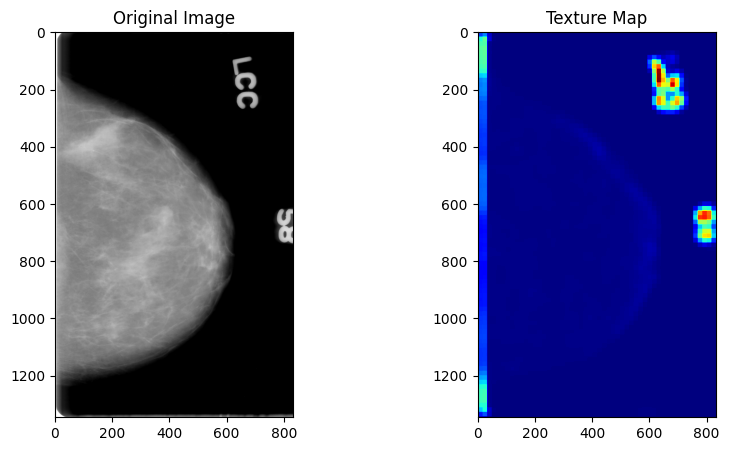

In [ ]:
import numpy as np
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage import transform

# Load the downsampled mammogram as an image matrix
img = transform.resize(left_cc_benign, (left_cc_benign.shape[0]//4, left_cc_benign.shape[1]//4))
# Convert the image to an unsigned integer type
img = np.round(img * 255).astype(np.uint8)


# Define the size of the chunks
chunk_size = 32

# Define the stride of the sliding window
stride = 16

# Initialize the texture feature map
texture_map = np.zeros_like(img, dtype=np.float64)

# Iterate through the downsampled mammogram and extract overlapping chunks
glcm_list = []
for i in range(0, img.shape[0] - chunk_size + 1, stride):
    for j in range(0, img.shape[1] - chunk_size + 1, stride):
        chunk = img[i:i+chunk_size, j:j+chunk_size]

        # Compute the GLCM of each chunk
        glcm = skimage.feature.graycomatrix(chunk, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_list.append(glcm)

        # Compute the Contrast feature for each GLCM
        contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
        
        # Store the Contrast feature in the texture map
        texture_map[i:i+chunk_size, j:j+chunk_size] += contrast

print(f"Number of GLCMs computed: {len(glcm_list)}")
print(f"Texture map shape: {texture_map.shape}")




# Plot the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')

# Plot the texture map
ax2.imshow(texture_map, cmap='jet')
ax2.set_title('Texture Map')
plt.show()


## Problem 3: Tumor Classification (49 Points)

In addition to the [mammograms themselves (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH), which is based on [this](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on these feature table using the algorithms presented to you last year in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any package or use your own (custom code, sklearn, keras, Tensorflow, pytorch, timm etc.). If you dont want to place helper functions and classes into this notebook, place them in a .py file in the same folder called helperfunctions.py and import them into this notebook.

The delivery should be a report which includes the experiment planning, the extracted features and the results.
Try answering in your report the following questions:
- Which method(s) did you use? 
- Why did you choose these method(s)?
- What were your expectations towards these methods?
- How did they perform compared to your expectations?
- Which metrics did you use? To which ones did you pay the most attention?
- How do you feel about your results? 
- How would you plan to improve your results further?  

###Report


*   a Convolutional Neural Network (CNN) consisting of a series of convolutional, pooling, and dense layers, as well as a dropout layer to prevent overfitting. The model is then trained using the Adam optimizer and the Sparse Categorical Crossentropy loss function.

*  My expectation was to accurately classify the mammography images into one of the three possible classes and to do so while avoiding overfitting, using regularization techniques such as dropout.

* The model seems to have performed reasonably well, achieving a validation accuracy of around 68% after two epochs of training. 

* The metrics used were the loss, accuracy and a confusion matrix to evaluate how well the model is performing in terms of correctly predicting each class.

* To improve the results further, I would consider increasing the amount of training data, optimizing the parameters (like the learning rate and number of epochs), or using more advanced techniques such as data augmentation or transfer learning.


In [ ]:
import tensorflow as tf
import pandas as pd 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import os 
import pathlib 
import random
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import layers 
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
### WRITE CODE IN HERE. ##############################################################################

data_dir = pathlib.Path('/content/drive/MyDrive/Dataset_BUSI_with_GT_/Dataset_BUSI_with_GT')
benignPath = os.path.join(data_dir,'benign')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')

class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))



batch_size = 32
img_height = 224
img_width = 224



train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)




######################################################################################################

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [ ]:

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

In [ ]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

In [ ]:
epochs = 2
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, 
                    batch_size=batch_size)

Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 159s 2s/step - loss: 0.9102 - accuracy: 0.5764 - val_loss: 0.8058 - val_accuracy: 0.6825
Epoch 2/2
40/40 [==============================] - 64s 2s/step - loss: 0.6584 - accuracy: 0.7078 - val_loss: 0.7227 - val_accuracy: 0.6571


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

1/1 [==============================] - 0s 29ms/step


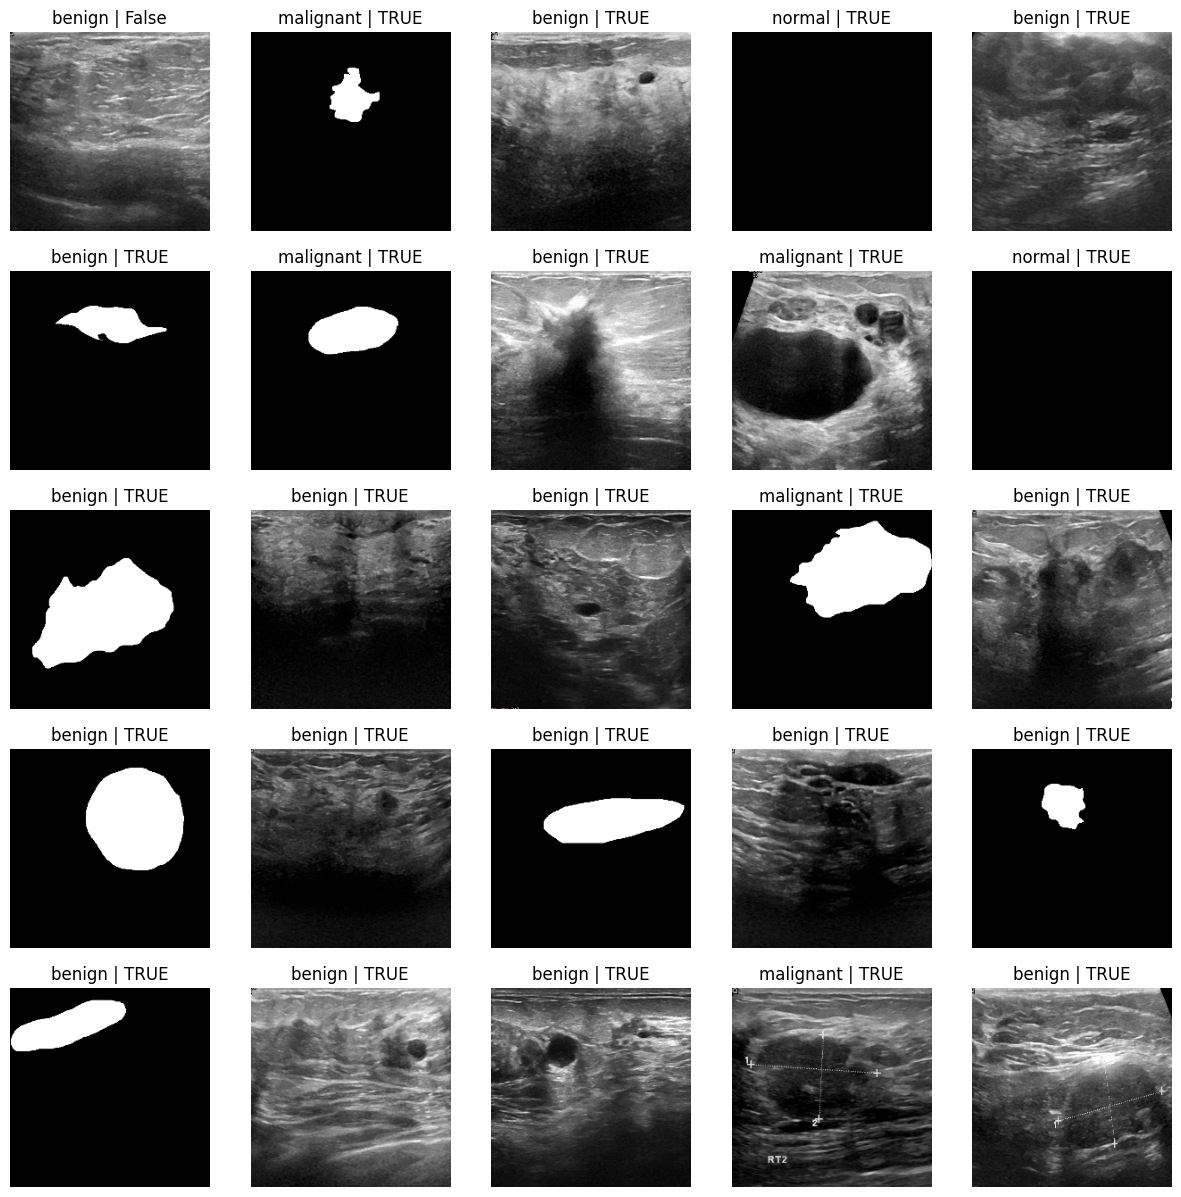

In [ ]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

1/1 [==============================] - 0s 314ms/step


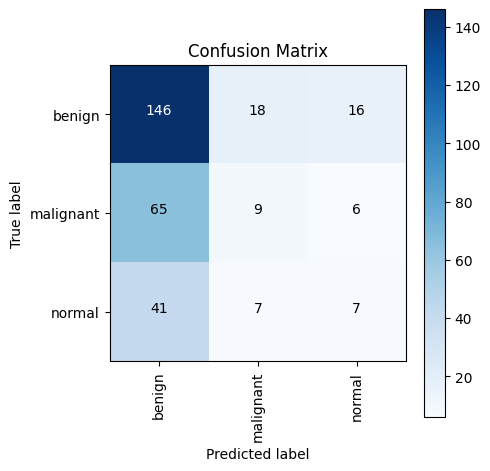

In [ ]:


# Get the predicted class labels for the validation dataset
y_pred = []
for images, labels in val_data:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Get the true class labels for the validation dataset
y_true = []
for images, labels in val_data:
    y_true.extend(labels.numpy())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = train_data.class_names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
